In [1]:
#Presente par Ahmed Mohamed, Sofiene Fehri, Abdessalam Nahnah, Mouard Benchickh

import numpy as np
from tqdm import *
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from skimage.feature import hog
from sklearn.utils import shuffle
import time

from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def create_datasets(data, percent):
    idx = 1-int(percent * len(data))
    return data[:idx], data[idx:]

In [0]:
def g_x(func_type, z):
    if func_type == 'softmax':
        z = np.exp(z-np.max(z)) / np.sum(np.exp(z-np.max(z)), axis=0, keepdims=True)
    elif func_type == 'sigmoid':
        z = 1/(1+np.exp(-z))

    elif func_type == 'relu':
        z[z<0] = 0

    elif func_type == 'tanh':
        z = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
        
    return z

def gPrime_x(func_type, z):
    if func_type == 'softmax':
        zPrime = (z @ np.ones((1, len(z)))) * (np.identity(len(z)) - (np.ones((len(z), 1))@ z.T))

    elif func_type == 'sigmoid':
        zPrime = (1/(1+np.exp(-z)))*(1-(1/(1+np.exp(-z))))

    elif func_type == 'relu':
        zPrime = np.where(z>0,1,0)
        
    elif func_type == 'tanh':
        zPrime = (1 - np.power(z, 2))
    
    return zPrime
            

In [0]:
def plot(models):
    models = np.array(models)
    
    if models.any().plot_errors == True:
        plot_errors(models)


    if models.any().plot_decision == True and models.any().image == False:
        plt_dec_boundary(models)
    

def plot_errors(models):
    x_size = int(np.ceil(np.sqrt(len(models))))
    y_size = int(np.ceil(np.sqrt(len(models))))
    fig, axs = plt.subplots(x_size, y_size, figsize=(10,10), squeeze=False)
    fig.suptitle("Errors",  fontweight="bold", fontsize=15)
    i,j = 0, 0

    for model in models:
        if model.plot_errors:
            axs[i][j].set_title(model.plot_errors_title, size=10)
            axs[i][j].plot(model.train_errors/max(model.train_errors), label="Train errors")
            axs[i][j].plot(model.test_errors, label = "Test errors")
            if model.valid_percent > 0:
                 axs[i][j].plot(model.validation_errors/max(model.validation_errors), label = "Cross validation errors")
            axs[i][j].set_xlabel('Epochs',fontsize = 10)
            axs[i][j].set_ylabel('Errors',fontsize = 10)
            if (j+1)%y_size == 0:
                i+=1
                j=0
            else : j+=1
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right')

    plt.show()

    
def plt_dec_boundary(models):
    # Set min and max values and give it some padding
    x_size = int(np.ceil(np.sqrt(len(models))))
    y_size = int(np.ceil(np.sqrt(len(models))))
    fig, axs = plt.subplots(x_size, y_size, constrained_layout=True, figsize=(100,100), squeeze=False)
    fig.suptitle("Decision boundaries", fontsize=10)
    i,j = 0, 0
    for model in models:
        if model.plot_decision:
            X = model.train_inputs
            Y = model.train_labels
            x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
            y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
            h = 0.01
            # Generate a grid of points with distance h between them
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            # Predict the function value for the whole grid
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            # Plot the contour and training examples
            axs[i][j].contourf(xx, yy, Z, cmap=plt.cm.Spectral)
            axs[i][j].set_title(model.plot_decision_title, size=6)
            axs[i][j].set_xlabel('x1',fontsize = 6)
            axs[i][j].set_ylabel('x2',fontsize = 6)
            axs[i][j].scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
            if (j+1)%y_size == 0:
                i+=1
                j=0
            else : j+=1
            

    plt.show()

In [0]:
class NeuralNetwork:
    def __init__(self, sizes):
        np.random.seed(0)

        self.sizes      = sizes
        self.model      = {}
        self.b          = np.array([np.zeros((x, 1))  for x in sizes[1:]])
        self.d          = self.sizes[0]  
        self.s          = self.sizes[-1]      
        self.w          = np.array([(np.random.randn(x, y) / np.sqrt(x)) for x,y in zip(self.sizes[1:],self.sizes[:-1])])
        for w in self.w:
            w = np.random.uniform(-1/np.sqrt(w.shape[1]), 1/np.sqrt(w.shape[1]),(w.shape[0],w.shape[1]))

    def fprop(self,x):
        model = {}
        for j in range(1,len(self.sizes)):
            weight_j = 'W{}'.format(j)  
            bias_j = 'b{}'.format(j)
            model[weight_j] = self.w[j-1]
            model[bias_j] = self.b[j-1]

        model['a0'] = x
        for i in range(1,len(self.sizes)):
           
            z = model['W'+str(i)] @ model['a'+str(i-1)] + model['b'+str(i)]
            model['z'+str(i)] = z
            a = g_x(self.h_act,z) if i < (len(self.sizes)-1) else g_x(self.out_act,z) 
            model['a'+str(i)] = a
       
        self.model = model
       

    def bprop(self,y):
        delta_last = self.model['a'+str(len(self.sizes)-1)] - y
        self.model['delta'+str(len(self.sizes)-1)] = delta_last
                
        for j in range(len(self.sizes)-1,0,-1):
            a = self.model['a'+str(j-1)]
            delta = self.model['delta'+str(j)]
            self.model['grad_w'+str(j)] = delta @ a.T 
            #_lambda *    
            self.model['grad_b'+str(j)] = np.sum(delta, axis=1, keepdims=True)
            if (j>1):
                z = self.model['z'+str(j-1)]
                self.model['delta'+str(j-1)] = ((delta.T@self.model['W'+str(j)]).T * (gPrime_x(self.h_act,z))) 
                + (self.L1_lambda * np.divide(np.array([w for w in self.w]),np.abs(np.array([w for w in self.w]))))
                + (self.L2_lambda*np.array([w for w in self.w]))

    def train(self, data, epochs, minibatch_size, L1_lambda, L2_lambda, lrate, lrate_decay, h_act, out_act, test, images,
              check_grad, vector_minibatch, valid_percent):
        
        self.minibatch_size    = minibatch_size
        self.L1_lambda         = L1_lambda
        self.L2_lambda         = L2_lambda
        self.lrate             = lrate
        self.lrate_decay       = lrate_decay
        self.h_act             = h_act
        self.out_act           = out_act 
        self.train_errors      = []
        self.check_grad        = check_grad
        self.epochs            = epochs
        self.test              = test
        self.validation_errors = []
        self.test_errors       = []
        self.valid_percent     = valid_percent
            
        self.train_inputs = data['train_inputs']
        self.train_labels = data['train_labels']
        self.test_inputs = data['test_inputs']
        self.onehot = self.onehot_encode(np.array(self.train_labels))

        try: 
            self.test_labels = data['test_labels']

            self.test_onehot = self.onehot_encode(self.test_labels)
        except:
            pass

        
        if images :
            self.train_inputs = np.array(self.train_inputs)
            sqrt = int(np.sqrt(self.train_inputs.shape[1]))
            length = self.train_inputs.shape[0]
            self.train_inputs = self.train_inputs.reshape((length,sqrt,sqrt))
            self.train_inputs = self.images_preprocessing(self.train_inputs)
                

            self.test_inputs = np.array(self.test_inputs)
            length = self.test_inputs.shape[0]
            self.test_inputs = self.test_inputs.reshape((length,sqrt,sqrt))
            self.test_inputs = self.images_preprocessing(self.test_inputs)


            if self.sizes[0] != self.train_inputs.shape[1]:
                self.sizes[0] = self.train_inputs.shape[1]
                self.d          = self.sizes[0]  
                self.b          = np.array([np.zeros((x, 1))  for x in self.sizes[1:]])
                self.w          = np.array([(np.random.randn(x, y) / np.sqrt(x)) for x,y in zip(self.sizes[1:],self.sizes[:-1])])
                for w in self.w:
                    w = np.random.uniform(-1/np.sqrt(w.shape[1]), 1/np.sqrt(w.shape[1]),(w.shape[0],w.shape[1]))

        if valid_percent > 0:
            self.cross_validation_and_test()

        else : 
            self.training_type()

    def cross_validation_and_test(self):
        folds = int(np.floor(1/self.valid_percent))
        kf = KFold(n_splits=folds) 
        kf.get_n_splits(self.train_inputs)
        i = 0 
        train_inputs = self.train_inputs
        train_labels = self.train_labels

        for train_index, test_index in kf.split(np.array(self.train_inputs)):
            self.train_inputs = train_inputs
            self.train_labels = train_labels
            train_index = train_index[train_index<len(self.train_inputs)]
            test_index = test_index[test_index<len(self.train_inputs)]
            try:
                self.train_inputs, self.train_labels = self.train_inputs[train_index], self.train_labels[train_index]
                self.validation_inputs, self.validation_labels = self.train_inputs[test_index], self.train_labels[test_index]
                self.validation_onehot = self.onehot_encode(self.validation_labels)
                self.training_type()
                tqdm.write("\nFold {0}/{1} complete : \nCross validation error : {2}\n".format(i+1,folds,validation_error))
                
            except:
                continue
            i+=1

    def training_type(self):

        if self.minibatch_size == 0:
            self.train_SGD()

        elif self.minibatch_size < len(self.train_inputs) and vector_minibatch:
            self.train_vector_minibatch()

        elif self.minibatch_size < len(self.train_inputs) and not vector_minibatch:
            self.train_minibatch()

        else : self.train_batch()


    def train_SGD(self):


        x = self.train_inputs
        y = self.onehot

        if(type(self.train_errors) != 'list'):
            self.train_errors = list(self.train_errors)

        tic = time.time()
        for j in tqdm(range(self.epochs)):
    
            self.train_inputs,self.train_labels = shuffle(self.train_inputs, self.train_labels, random_state=0)
            total_loss_per_epoch = 0
            stopped = False
            data_left = 0
            L = 0

            for i in range(len(x)):
                x_i = x[i].reshape(self.d,1)
                y_i = y[i].reshape((self.s,1))
                self.fprop(x_i)
                self.bprop(y_i)
                self.update_param()
                L += self.loss_function(y_i)
            
            total_loss_per_epoch += L

            self.train_errors.append(total_loss_per_epoch)

            tqdm.write("Epoch {0} complete : \nLoss : {:.5f}\nMean Training Loss : {:.5f}\n".format(j,total_loss_per_epoch,
                (total_loss_per_epoch/len(x))))

            if self.valid_percent > 0 :
                evaluation = self.evaluate(self.validation_inputs, self.validation_onehot)
                tqdm.write("Cross validation score: {0}\n".format(evaluation))
                self.validation_errors.append(1-evaluation)


            if self.test:
                evaluation = self.evaluate(self.test_inputs, self.test_onehot)
                tqdm.write("Test score: {0}\n".format(evaluation))
                self.test_errors.append((1-evaluation))

            if self.lrate_decay and self.lrate > 0: self.lrate *= self.lrate_decay
            
            
        toc = time.time()

        print("\nTime taken for non vectorial mini batch :", str(toc - tic))

        if self.check_grad :
            self.verif_gradient(x,y)
        

    def train_minibatch(self,validation):

        x = self.train_inputs
        y = self.onehot

        total_loss_per_epoch = 0
        stopped = False
        data_left = 0
        if(type(self.train_errors) != 'list'):
            self.train_errors = list(self.train_errors)

        tic = time.time()

        for j in tqdm(range(self.epochs)):

            L = 0
            self.train_inputs,self.train_labels = shuffle(self.train_inputs, self.train_labels, random_state=0)

            for i in range(0, self.train_inputs.shape[0] -data_left, self.minibatch_size):
                x_minibatch = self.train_inputs[i:i+ self.minibatch_size]
                y_minibatch = self.onehot[i:i+ self.minibatch_size]
                data_left = len(self.train_inputs)%self.minibatch_size

                if data_left == 0:
                    stopped = True

                for i in range(len(x)):
                    x_i = x[i].reshape(self.d,1)
                    y_i = y[i].reshape((self.s,1))
                    self.fprop(x_i)
                    self.bprop(y_i)
                    self.update_param()
                    L += self.loss_function(y_i)

            
            total_loss_per_epoch = L
            self.train_errors.append(total_loss_per_epoch)

            tqdm.write("Epoch {0} complete : \nLoss : {:.5f}\nMean Training Loss : {:.5f}".format(j,total_loss_per_epoch,
                (total_loss_per_epoch/len(x))))

            if self.test:
                test_errors, evaluation = self.evaluate(self.test_inputs, self.test_onehot)
                tqdm.write("Test score: {:.5f}  ".format(evaluation))
                self.test_errors.append(1-evaluation)

            if self.lrate_decay and self.lrate > 0: self.lrate *= self.lrate_decay
        
        toc = time.time()

        print("\nTime taken for non vectorial mini batch :", str(toc - tic))

        if self.check_grad :
            self.verif_gradient(x,y)

      
    def onehot_encode(self,y):
      lb = LabelBinarizer()
      y = lb.fit_transform(y)     
      return y

    def verif_gradient(self,x,y,epsilon= 10**-5):
        for i in range(len(x)):
            x_i = x[i].reshape((self.d,1))
            y_i = y[i].reshape((self.s,1))
            self.fprop(x_i)
            L = self.loss_function(y_i)
            self.bprop(y_i)
            gradients_w = [self.model['grad_w'+str(i+1)] for i in range(len(self.w))]
            gradients_b = [self.model['grad_b'+str(i+1)] for i in range(len(self.w))]
            ratio_w = []
            ratio_b = []
            for k,matrix_weight in enumerate (self.w):
                shape = matrix_weight.shape
                for i in range(shape[0]):
                    for j in range(shape[1]):
                        matrix_weight[i][j] -= epsilon                    
                        self.fprop(x_i)
                        L2 = self.loss_function(y_i)
                        estimated_gradient = (L-L2)/epsilon
                        matrix_weight[i][j] += epsilon
                        ratio_w.append(np.float64((estimated_gradient+epsilon)/(gradients_w[k][i][j]+epsilon)))   

       
        print(ratio_w)

    def update_param(self):
        for i in range(len(self.w)-1,-1,-1):
             self.w[i] -= self.lrate * self.model['grad_w'+str(i+1)]
             self.b[i] -= self.lrate * self.model['grad_b'+str(i+1)]

    def loss_function(self,y):
        p = self.model['a'+str(len(self.sizes)-1)]
        x = np.sum(p*y, axis = 0)
        return (((-np.log(x+10**-5)) + 0.5 *self.L1_lambda * np.abs(self.w)) + 0.5*self.L2_lambda*(self.w**2))[0][0][0]

    def evaluate(self, test_data, test_labels, func_type='sgd'):
        activations = []
        test_results = []

        # test_data,test_labels = shuffle(test_data,test_labels, random_state=1)

        for i in range(len(test_data)):
            if func_type == 'sgd':
                self.fprop(np.array([test_data[i]]).T)
                test_results.append(((np.argmax(np.sum(self.model['a'+str(len(self.sizes)-1)],axis=1)))
                                     == np.argmax(test_labels[i])))

            else :
                self.fprop(np.array(test_data.T))
                test_results.append(((np.argmax(np.sum(self.model['a'+str(len(self.sizes)-1)],axis=1)))
                                     == np.argmax(test_labels)))
            
        return (np.sum(np.array(test_results)*1))/len(test_labels)

    def predict(self, test_inputs):
        test_results = []
        for i in range(len(test_inputs)):
            self.fprop(np.array([test_inputs[i]]).T)
            test_results.append(np.max((np.sum(self.model['a'+str(len(self.sizes)-1)],axis=1))))
        test_results = np.array(test_results)

        return test_results.reshape((len(test_results),1))

    def images_preprocessing(self,images):
        list_hog_fd = []
        for feature in tqdm(images):
                fd = hog(feature, orientations=4, pixels_per_cell=(50, 50), cells_per_block=(1, 1))
                list_hog_fd.append(fd)
        return np.array(list_hog_fd, 'float64')

    def figures_plot(self,plot_type,title):
        if 'error' in plot_type:
            self.plot_errors = True
            self.plot_errors_title = title

        elif 'decision' in plot_type:
            self.plot_decision = True
            self.plot_decision_title = title

    

In [0]:
def load_images(path,test_percent,valid_percent,mnist = False,kaggle = True) :
  train = np.load(path+"train_images.npy", encoding = 'bytes')
  # test = np.load(path+"test_images.npy", encoding = 'bytes')
  train_inputs = np.array(list([x for x in train[:,1]]))
  # test_inputs  = np.array(list([x for x in test[:,1]]))
  train_inputs,test_inputs = create_datasets(train_inputs,test_percent)
  train_labels = pd.read_csv(path+"train_labels.csv")
  train_labels = train_labels['Category']
  train_labels,test_labels = create_datasets(train_labels,test_percent)

  datasets = {'train_inputs':train_inputs,'train_labels':train_labels,
          'test_inputs':test_inputs,'test_labels':test_labels}
  return datasets

In [0]:
valid_percent = 0
images = True
mnist = False
kaggle = False
csv = False
lambda1 = 0
lambda2 = 0
h_act = 'relu'
out_act = 'softmax'
test = True
minibatch_size = 0
valid_percent = 0
lrate_decay = 0
check_grad = False
vector_minibatch = False
test_plot_boundaries = False
sizes = [10000,450,31]
epochs = 200
lrate  = 0.01
test_percent = 0.25
path = "/content/gdrive/My Drive/notebooks/"

data = load_images(path,test_percent,valid_percent,mnist = False,kaggle = True) 
model = NeuralNetwork(sizes)

model.train(data, epochs , minibatch_size, lambda1, lambda2, lrate, lrate_decay, h_act, out_act , test, 
                  images,check_grad, vector_minibatch,valid_percent)

  0%|          | 0/7501 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
  0%|          | 0/200 [00:07<?, ?it/s]

Epoch 0 complete : 
Loss : 25413.934516965557
Mean Training Loss : 3.388072859214179



  0%|          | 1/200 [00:07<25:56,  7.82s/it]

Test score: 0.04721888755502201



  0%|          | 1/200 [00:15<25:56,  7.82s/it]

Epoch 1 complete : 
Loss : 25373.799923412756
Mean Training Loss : 3.38272229348257



  1%|          | 2/200 [00:15<25:51,  7.84s/it]

Test score: 0.04721888755502201



  1%|          | 2/200 [00:23<25:51,  7.84s/it]

Epoch 2 complete : 
Loss : 25353.500724303158
Mean Training Loss : 3.380016094427831



  2%|▏         | 3/200 [00:23<25:46,  7.85s/it]

Test score: 0.04721888755502201



  2%|▏         | 3/200 [00:31<25:46,  7.85s/it]

Epoch 3 complete : 
Loss : 25336.69805318568
Mean Training Loss : 3.3777760369531635



  2%|▏         | 4/200 [00:31<25:38,  7.85s/it]

Test score: 0.04801920768307323



  2%|▏         | 4/200 [00:38<25:38,  7.85s/it]

Epoch 4 complete : 
Loss : 25313.49642972046
Mean Training Loss : 3.374682899576118



  2%|▎         | 5/200 [00:39<25:32,  7.86s/it]

Test score: 0.05042016806722689



  2%|▎         | 5/200 [00:46<25:32,  7.86s/it]

Epoch 5 complete : 
Loss : 25289.45571377532
Mean Training Loss : 3.371477898116961



  3%|▎         | 6/200 [00:47<25:26,  7.87s/it]

Test score: 0.06522609043617447



  3%|▎         | 6/200 [00:54<25:26,  7.87s/it]

Epoch 6 complete : 
Loss : 25257.228020113344
Mean Training Loss : 3.3671814451557585



  4%|▎         | 7/200 [00:55<25:26,  7.91s/it]

Test score: 0.07242897158863545



  4%|▎         | 7/200 [01:02<25:26,  7.91s/it]

Epoch 7 complete : 
Loss : 25218.558110750288
Mean Training Loss : 3.3620261446140898



  4%|▍         | 8/200 [01:03<25:20,  7.92s/it]

Test score: 0.07963185274109644



  4%|▍         | 8/200 [01:10<25:20,  7.92s/it]

Epoch 8 complete : 
Loss : 25169.070179547532
Mean Training Loss : 3.3554286334552104



  4%|▍         | 9/200 [01:11<25:14,  7.93s/it]

Test score: 0.08563425370148059



  4%|▍         | 9/200 [01:18<25:14,  7.93s/it]

Epoch 9 complete : 
Loss : 25110.768388236098
Mean Training Loss : 3.3476560976184637



  5%|▌         | 10/200 [01:19<25:11,  7.96s/it]

Test score: 0.08043217286914765



  5%|▌         | 10/200 [01:26<25:11,  7.96s/it]

Epoch 10 complete : 
Loss : 25042.070098624088
Mean Training Loss : 3.3384975468103035



  6%|▌         | 11/200 [01:27<25:04,  7.96s/it]

Test score: 0.07523009203681473



  6%|▌         | 11/200 [01:34<25:04,  7.96s/it]

Epoch 11 complete : 
Loss : 24965.602020126855
Mean Training Loss : 3.3283031622619457



  6%|▌         | 12/200 [01:35<25:01,  7.99s/it]

Test score: 0.07523009203681473



  6%|▌         | 12/200 [01:43<25:01,  7.99s/it]

Epoch 12 complete : 
Loss : 24883.402668637482
Mean Training Loss : 3.3173447098570166



  6%|▋         | 13/200 [01:43<25:22,  8.14s/it]

Test score: 0.07643057222889156



  6%|▋         | 13/200 [01:51<25:22,  8.14s/it]

Epoch 13 complete : 
Loss : 24802.55695837592
Mean Training Loss : 3.3065667188876042



  7%|▋         | 14/200 [01:51<25:09,  8.12s/it]

Test score: 0.07803121248499399



  7%|▋         | 14/200 [01:59<25:09,  8.12s/it]

Epoch 14 complete : 
Loss : 24725.06127750871
Mean Training Loss : 3.296235338955967



  8%|▊         | 15/200 [01:59<24:53,  8.07s/it]

Test score: 0.07763105242096839



  8%|▊         | 15/200 [02:07<24:53,  8.07s/it]

Epoch 15 complete : 
Loss : 24654.091771951254
Mean Training Loss : 3.2867739997268703



  8%|▊         | 16/200 [02:07<24:38,  8.04s/it]

Test score: 0.07723089235694278



  8%|▊         | 16/200 [02:15<24:38,  8.04s/it]

Epoch 16 complete : 
Loss : 24590.841436804152
Mean Training Loss : 3.2783417460077526



  8%|▊         | 17/200 [02:15<24:31,  8.04s/it]

Test score: 0.07763105242096839



  8%|▊         | 17/200 [02:23<24:31,  8.04s/it]

Epoch 17 complete : 
Loss : 24532.244394093752
Mean Training Loss : 3.270529848566025



  9%|▉         | 18/200 [02:23<24:25,  8.05s/it]

Test score: 0.08283313325330131



  9%|▉         | 18/200 [02:31<24:25,  8.05s/it]

Epoch 18 complete : 
Loss : 24480.860201465897
Mean Training Loss : 3.2636795362572855



 10%|▉         | 19/200 [02:31<24:17,  8.05s/it]

Test score: 0.0820328131252501



 10%|▉         | 19/200 [02:39<24:17,  8.05s/it]

Epoch 19 complete : 
Loss : 24434.21519961688
Mean Training Loss : 3.2574610318113426



 10%|█         | 20/200 [02:39<24:08,  8.05s/it]

Test score: 0.08483393357342937



 10%|█         | 20/200 [02:47<24:08,  8.05s/it]

Epoch 20 complete : 
Loss : 24391.31675602407
Mean Training Loss : 3.251742001869627



 10%|█         | 21/200 [02:47<23:57,  8.03s/it]

Test score: 0.08563425370148059



 10%|█         | 21/200 [02:55<23:57,  8.03s/it]

Epoch 21 complete : 
Loss : 24351.57179168761
Mean Training Loss : 3.246443379774378



 11%|█         | 22/200 [02:56<24:07,  8.13s/it]

Test score: 0.08763505402160865



 11%|█         | 22/200 [03:04<24:07,  8.13s/it]

Epoch 22 complete : 
Loss : 24314.101328149914
Mean Training Loss : 3.241447984022119



 12%|█▏        | 23/200 [03:04<24:32,  8.32s/it]

Test score: 0.0896358543417367



 12%|█▏        | 23/200 [03:12<24:32,  8.32s/it]

Epoch 23 complete : 
Loss : 24278.364178786236
Mean Training Loss : 3.236683666016029



 12%|█▏        | 24/200 [03:12<24:04,  8.20s/it]

Test score: 0.09123649459783914



 12%|█▏        | 24/200 [03:20<24:04,  8.20s/it]

Epoch 24 complete : 
Loss : 24247.52791727085
Mean Training Loss : 3.232572712607766



 12%|█▎        | 25/200 [03:20<23:42,  8.13s/it]

Test score: 0.09283713485394157



 12%|█▎        | 25/200 [03:28<23:42,  8.13s/it]

Epoch 25 complete : 
Loss : 24218.023872344962
Mean Training Loss : 3.2286393643974085



 13%|█▎        | 26/200 [03:28<23:28,  8.09s/it]

Test score: 0.09323729491796719



 13%|█▎        | 26/200 [03:36<23:28,  8.09s/it]

Epoch 26 complete : 
Loss : 24191.777786387353
Mean Training Loss : 3.2251403528046065



 14%|█▎        | 27/200 [03:36<23:16,  8.07s/it]

Test score: 0.0936374549819928



 14%|█▎        | 27/200 [03:44<23:16,  8.07s/it]

Epoch 27 complete : 
Loss : 24166.621454722204
Mean Training Loss : 3.2217866224133056



 14%|█▍        | 28/200 [03:44<23:09,  8.08s/it]

Test score: 0.09283713485394157



 14%|█▍        | 28/200 [03:52<23:09,  8.08s/it]

Epoch 28 complete : 
Loss : 24145.410473041924
Mean Training Loss : 3.218958868556449



 14%|█▍        | 29/200 [03:53<23:06,  8.11s/it]

Test score: 0.09443777511004402



 14%|█▍        | 29/200 [04:00<23:06,  8.11s/it]

Epoch 29 complete : 
Loss : 24125.6792940506
Mean Training Loss : 3.2163283954206903



 15%|█▌        | 30/200 [04:01<22:55,  8.09s/it]

Test score: 0.0940376150460184



 15%|█▌        | 30/200 [04:08<22:55,  8.09s/it]

Epoch 30 complete : 
Loss : 24107.219325086437
Mean Training Loss : 3.2138673943589438



 16%|█▌        | 31/200 [04:09<22:44,  8.07s/it]

Test score: 0.0936374549819928



 16%|█▌        | 31/200 [04:16<22:44,  8.07s/it]

Epoch 31 complete : 
Loss : 24090.799367608375
Mean Training Loss : 3.2116783585666413



 16%|█▌        | 32/200 [04:17<22:34,  8.06s/it]

Test score: 0.09283713485394157



 16%|█▌        | 32/200 [04:24<22:34,  8.06s/it]

Epoch 32 complete : 
Loss : 24074.525404172746
Mean Training Loss : 3.2095087860515594



 16%|█▋        | 33/200 [04:25<22:29,  8.08s/it]

Test score: 0.09323729491796719



 16%|█▋        | 33/200 [04:33<22:29,  8.08s/it]

Epoch 33 complete : 
Loss : 24059.554724336165
Mean Training Loss : 3.20751296151662



 17%|█▋        | 34/200 [04:33<22:18,  8.06s/it]

Test score: 0.0940376150460184



 17%|█▋        | 34/200 [04:41<22:18,  8.06s/it]

Epoch 34 complete : 
Loss : 24044.390266360573
Mean Training Loss : 3.205491303340964



 18%|█▊        | 35/200 [04:41<22:09,  8.06s/it]

Test score: 0.09323729491796719



 18%|█▊        | 35/200 [04:49<22:09,  8.06s/it]

Epoch 35 complete : 
Loss : 24030.55039706551
Mean Training Loss : 3.2036462334442755



 18%|█▊        | 36/200 [04:49<22:06,  8.09s/it]

Test score: 0.0940376150460184



 18%|█▊        | 36/200 [04:57<22:06,  8.09s/it]

Epoch 36 complete : 
Loss : 24017.922424758108
Mean Training Loss : 3.201962728270645



 18%|█▊        | 37/200 [04:57<21:59,  8.10s/it]

Test score: 0.09203681472589036



 18%|█▊        | 37/200 [05:05<21:59,  8.10s/it]

Epoch 37 complete : 
Loss : 24004.83939882005
Mean Training Loss : 3.2002185573683577



 19%|█▉        | 38/200 [05:05<21:47,  8.07s/it]

Test score: 0.09323729491796719



 19%|█▉        | 38/200 [05:13<21:47,  8.07s/it]

Epoch 38 complete : 
Loss : 23993.824787298763
Mean Training Loss : 3.198750138288063



 20%|█▉        | 39/200 [05:13<21:37,  8.06s/it]

Test score: 0.09283713485394157



 20%|█▉        | 39/200 [05:21<21:37,  8.06s/it]

Epoch 39 complete : 
Loss : 23981.640475145465
Mean Training Loss : 3.1971257799154067



 20%|██        | 40/200 [05:21<21:30,  8.06s/it]

Test score: 0.09283713485394157



 20%|██        | 40/200 [05:29<21:30,  8.06s/it]

Epoch 40 complete : 
Loss : 23969.90966484637
Mean Training Loss : 3.1955618803954633



 20%|██        | 41/200 [05:29<21:25,  8.09s/it]

Test score: 0.09083633453381353



 20%|██        | 41/200 [05:37<21:25,  8.09s/it]

Epoch 41 complete : 
Loss : 23957.810071128497
Mean Training Loss : 3.193948816308292



 21%|██        | 42/200 [05:38<21:15,  8.07s/it]

Test score: 0.09203681472589036



 21%|██        | 42/200 [05:45<21:15,  8.07s/it]

Epoch 42 complete : 
Loss : 23946.867146748966
Mean Training Loss : 3.192489954239297



 22%|██▏       | 43/200 [05:46<21:08,  8.08s/it]

Test score: 0.09163665466186474



 22%|██▏       | 43/200 [05:53<21:08,  8.08s/it]

Epoch 43 complete : 
Loss : 23934.983184960052
Mean Training Loss : 3.1909056372430413



 22%|██▏       | 44/200 [05:54<21:02,  8.09s/it]

Test score: 0.09243697478991597



 22%|██▏       | 44/200 [06:04<21:02,  8.09s/it]

Epoch 44 complete : 
Loss : 23922.14410161177
Mean Training Loss : 3.1891939876832116



 22%|██▎       | 45/200 [06:05<23:02,  8.92s/it]

Test score: 0.09323729491796719



 22%|██▎       | 45/200 [06:20<23:02,  8.92s/it]

Epoch 45 complete : 
Loss : 23910.134609050725
Mean Training Loss : 3.1875929354820323



 23%|██▎       | 46/200 [06:21<28:31, 11.12s/it]

Test score: 0.0936374549819928



 23%|██▎       | 46/200 [06:30<28:31, 11.12s/it]

Epoch 46 complete : 
Loss : 23899.001411707824
Mean Training Loss : 3.1861087070667677



 24%|██▎       | 47/200 [06:31<27:15, 10.69s/it]

Test score: 0.0936374549819928



 24%|██▎       | 47/200 [06:38<27:15, 10.69s/it]

Epoch 47 complete : 
Loss : 23886.4538793039
Mean Training Loss : 3.184435925783749



 24%|██▍       | 48/200 [06:39<25:03,  9.89s/it]

Test score: 0.0940376150460184



 24%|██▍       | 48/200 [06:58<25:03,  9.89s/it]

Epoch 48 complete : 
Loss : 23875.802282800654
Mean Training Loss : 3.1830159022531204



 24%|██▍       | 49/200 [06:59<33:04, 13.14s/it]

Test score: 0.0940376150460184



 24%|██▍       | 49/200 [07:12<33:04, 13.14s/it]

Epoch 49 complete : 
Loss : 23864.049302742238
Mean Training Loss : 3.1814490471593437



 25%|██▌       | 50/200 [07:12<32:29, 13.00s/it]

Test score: 0.09443777511004402



 25%|██▌       | 50/200 [07:20<32:29, 13.00s/it]

Epoch 50 complete : 
Loss : 23852.694522638532
Mean Training Loss : 3.1799352783146957



 26%|██▌       | 51/200 [07:20<28:42, 11.56s/it]

Test score: 0.09483793517406963



 26%|██▌       | 51/200 [07:28<28:42, 11.56s/it]

Epoch 51 complete : 
Loss : 23841.02256481172
Mean Training Loss : 3.17837922474493



 26%|██▌       | 52/200 [07:28<26:00, 10.54s/it]

Test score: 0.0940376150460184



 26%|██▌       | 52/200 [07:36<26:00, 10.54s/it]

Epoch 52 complete : 
Loss : 23830.90700639071
Mean Training Loss : 3.177030663430304



 26%|██▋       | 53/200 [07:36<24:03,  9.82s/it]

Test score: 0.09603841536614646



 26%|██▋       | 53/200 [07:44<24:03,  9.82s/it]

Epoch 53 complete : 
Loss : 23817.71257401125
Mean Training Loss : 3.1752716403161245



 27%|██▋       | 54/200 [07:45<22:42,  9.33s/it]

Test score: 0.09643857543017206



 27%|██▋       | 54/200 [07:53<22:42,  9.33s/it]

Epoch 54 complete : 
Loss : 23805.662240882768
Mean Training Loss : 3.1736651434319114



 28%|██▊       | 55/200 [07:53<21:48,  9.02s/it]

Test score: 0.09643857543017206



 28%|██▊       | 55/200 [08:01<21:48,  9.02s/it]

Epoch 55 complete : 
Loss : 23795.00156541138
Mean Training Loss : 3.1722439095335795



 28%|██▊       | 56/200 [08:01<20:59,  8.75s/it]

Test score: 0.09683873549419768



 28%|██▊       | 56/200 [08:09<20:59,  8.75s/it]

Epoch 56 complete : 
Loss : 23785.004717131967
Mean Training Loss : 3.170911174127712



 28%|██▊       | 57/200 [08:10<20:55,  8.78s/it]

Test score: 0.09563825530212085



 28%|██▊       | 57/200 [08:18<20:55,  8.78s/it]

Epoch 57 complete : 
Loss : 23772.833131907362
Mean Training Loss : 3.1692885124526544



 29%|██▉       | 58/200 [08:18<20:33,  8.69s/it]

Test score: 0.09523809523809523



 29%|██▉       | 58/200 [08:26<20:33,  8.69s/it]

Epoch 58 complete : 
Loss : 23762.091530570044
Mean Training Loss : 3.1678564898773556



 30%|██▉       | 59/200 [08:27<20:02,  8.53s/it]

Test score: 0.09483793517406963



 30%|██▉       | 59/200 [08:34<20:02,  8.53s/it]

Epoch 59 complete : 
Loss : 23753.378329667925
Mean Training Loss : 3.1666948846377716



 30%|███       | 60/200 [08:35<19:36,  8.40s/it]

Test score: 0.09723889555822329



 30%|███       | 60/200 [08:42<19:36,  8.40s/it]

Epoch 60 complete : 
Loss : 23745.737916940252
Mean Training Loss : 3.1656762987522



 30%|███       | 61/200 [08:43<19:16,  8.32s/it]

Test score: 0.09883953581432572



 30%|███       | 61/200 [08:51<19:16,  8.32s/it]

Epoch 61 complete : 
Loss : 23734.059512277207
Mean Training Loss : 3.164119385718865



 31%|███       | 62/200 [08:51<19:02,  8.28s/it]

Test score: 0.09723889555822329



 31%|███       | 62/200 [08:59<19:02,  8.28s/it]

Epoch 62 complete : 
Loss : 23726.436093159788
Mean Training Loss : 3.1631030653459256



 32%|███▏      | 63/200 [08:59<18:52,  8.26s/it]

Test score: 0.0976390556222489



 32%|███▏      | 63/200 [09:07<18:52,  8.26s/it]

Epoch 63 complete : 
Loss : 23717.56253873045
Mean Training Loss : 3.1619200824863953



 32%|███▏      | 64/200 [09:07<18:35,  8.20s/it]

Test score: 0.09843937575030012



 32%|███▏      | 64/200 [09:15<18:35,  8.20s/it]

Epoch 64 complete : 
Loss : 23705.118061227375
Mean Training Loss : 3.16026104002498



 32%|███▎      | 65/200 [09:15<18:21,  8.16s/it]

Test score: 0.09963985594237695



 32%|███▎      | 65/200 [09:23<18:21,  8.16s/it]

Epoch 65 complete : 
Loss : 23697.89617808897
Mean Training Loss : 3.1592982506451097



 33%|███▎      | 66/200 [09:23<18:11,  8.15s/it]

Test score: 0.09723889555822329



 33%|███▎      | 66/200 [09:31<18:11,  8.15s/it]

Epoch 66 complete : 
Loss : 23693.82692709758
Mean Training Loss : 3.1587557561788535



 34%|███▎      | 67/200 [09:31<17:59,  8.12s/it]

Test score: 0.0976390556222489



 34%|███▎      | 67/200 [09:39<17:59,  8.12s/it]

Epoch 67 complete : 
Loss : 23683.5811221783
Mean Training Loss : 3.1573898309796427



 34%|███▍      | 68/200 [09:40<17:47,  8.09s/it]

Test score: 0.0976390556222489



 34%|███▍      | 68/200 [09:47<17:47,  8.09s/it]

Epoch 68 complete : 
Loss : 23675.99913586961
Mean Training Loss : 3.1563790342447153



 34%|███▍      | 69/200 [09:48<17:44,  8.13s/it]

Test score: 0.09723889555822329



 34%|███▍      | 69/200 [09:56<17:44,  8.13s/it]

Epoch 69 complete : 
Loss : 23667.121139067094
Mean Training Loss : 3.155195459147726



 35%|███▌      | 70/200 [09:56<17:39,  8.15s/it]

Test score: 0.09723889555822329



 35%|███▌      | 70/200 [10:04<17:39,  8.15s/it]

Epoch 70 complete : 
Loss : 23661.755490868418
Mean Training Loss : 3.154480134764487



 36%|███▌      | 71/200 [10:04<17:32,  8.16s/it]

Test score: 0.09963985594237695



 36%|███▌      | 71/200 [10:12<17:32,  8.16s/it]

Epoch 71 complete : 
Loss : 23651.892477178713
Mean Training Loss : 3.153165241591616



 36%|███▌      | 72/200 [10:12<17:24,  8.16s/it]

Test score: 0.09963985594237695



 36%|███▌      | 72/200 [10:20<17:24,  8.16s/it]

Epoch 72 complete : 
Loss : 23644.241818899278
Mean Training Loss : 3.152145289814595



 36%|███▋      | 73/200 [10:20<17:16,  8.16s/it]

Test score: 0.09923969587835134



 36%|███▋      | 73/200 [10:28<17:16,  8.16s/it]

Epoch 73 complete : 
Loss : 23635.20393927333
Mean Training Loss : 3.1509403998497976



 37%|███▋      | 74/200 [10:29<17:08,  8.16s/it]

Test score: 0.09843937575030012



 37%|███▋      | 74/200 [10:36<17:08,  8.16s/it]

Epoch 74 complete : 
Loss : 23629.254755102782
Mean Training Loss : 3.1501472810428983



 38%|███▊      | 75/200 [10:37<16:58,  8.15s/it]

Test score: 0.10044017607042817



 38%|███▊      | 75/200 [10:44<16:58,  8.15s/it]

Epoch 75 complete : 
Loss : 23624.253779694023
Mean Training Loss : 3.1494805732161075



 38%|███▊      | 76/200 [10:45<16:50,  8.15s/it]

Test score: 0.10084033613445378



 38%|███▊      | 76/200 [10:53<16:50,  8.15s/it]

Epoch 76 complete : 
Loss : 23615.99884218143
Mean Training Loss : 3.1483800616159754



 38%|███▊      | 77/200 [10:53<16:47,  8.19s/it]

Test score: 0.101640656262505



 38%|███▊      | 77/200 [11:01<16:47,  8.19s/it]

Epoch 77 complete : 
Loss : 23612.031540887972
Mean Training Loss : 3.147851158630579



 39%|███▉      | 78/200 [11:01<16:39,  8.19s/it]

Test score: 0.09883953581432572



 39%|███▉      | 78/200 [11:09<16:39,  8.19s/it]

Epoch 78 complete : 
Loss : 23607.423769899142
Mean Training Loss : 3.1472368710704095



 40%|███▉      | 79/200 [11:10<16:30,  8.19s/it]

Test score: 0.09723889555822329



 40%|███▉      | 79/200 [11:17<16:30,  8.19s/it]

Epoch 79 complete : 
Loss : 23598.19676568583
Mean Training Loss : 3.1460067678557295



 40%|████      | 80/200 [11:18<16:21,  8.18s/it]

Test score: 0.09843937575030012



 40%|████      | 80/200 [11:25<16:21,  8.18s/it]

Epoch 80 complete : 
Loss : 23592.01011620002
Mean Training Loss : 3.145181991227839



 40%|████      | 81/200 [11:26<16:13,  8.18s/it]

Test score: 0.09963985594237695



 40%|████      | 81/200 [11:34<16:13,  8.18s/it]

Epoch 81 complete : 
Loss : 23585.08939656365
Mean Training Loss : 3.1442593516282695



 41%|████      | 82/200 [11:34<16:03,  8.17s/it]

Test score: 0.10004001600640255



 41%|████      | 82/200 [11:42<16:03,  8.17s/it]

Epoch 82 complete : 
Loss : 23577.880907198807
Mean Training Loss : 3.1432983478467946



 42%|████▏     | 83/200 [11:42<16:00,  8.21s/it]

Test score: 0.09923969587835134



 42%|████▏     | 83/200 [11:51<16:00,  8.21s/it]

Epoch 83 complete : 
Loss : 23570.324440446402
Mean Training Loss : 3.1422909532657517



 42%|████▏     | 84/200 [11:51<16:24,  8.49s/it]

Test score: 0.09963985594237695



 42%|████▏     | 84/200 [11:59<16:24,  8.49s/it]

Epoch 84 complete : 
Loss : 23564.91964804956
Mean Training Loss : 3.1415704103518944



 42%|████▎     | 85/200 [12:00<16:05,  8.39s/it]

Test score: 0.09963985594237695



 42%|████▎     | 85/200 [12:07<16:05,  8.39s/it]

Epoch 85 complete : 
Loss : 23556.189193134887
Mean Training Loss : 3.1404065048840004



 43%|████▎     | 86/200 [12:08<15:49,  8.33s/it]

Test score: 0.10084033613445378



 43%|████▎     | 86/200 [12:16<15:49,  8.33s/it]

Epoch 86 complete : 
Loss : 23551.605066448887
Mean Training Loss : 3.1397953694772545



 44%|████▎     | 87/200 [12:16<15:35,  8.28s/it]

Test score: 0.09843937575030012



 44%|████▎     | 87/200 [12:24<15:35,  8.28s/it]

Epoch 87 complete : 
Loss : 23544.186010035468
Mean Training Loss : 3.138806293832218



 44%|████▍     | 88/200 [12:24<15:23,  8.25s/it]

Test score: 0.09803921568627451



 44%|████▍     | 88/200 [12:32<15:23,  8.25s/it]

Epoch 88 complete : 
Loss : 23537.0393858536
Mean Training Loss : 3.137853537642128



 44%|████▍     | 89/200 [12:32<15:12,  8.22s/it]

Test score: 0.10004001600640255



 44%|████▍     | 89/200 [12:40<15:12,  8.22s/it]

Epoch 89 complete : 
Loss : 23533.66927108623
Mean Training Loss : 3.1374042489116425



 45%|████▌     | 90/200 [12:40<15:00,  8.19s/it]

Test score: 0.10004001600640255



 45%|████▌     | 90/200 [12:48<15:00,  8.19s/it]

Epoch 90 complete : 
Loss : 23523.540215934212
Mean Training Loss : 3.1360538882727917



 46%|████▌     | 91/200 [12:49<14:57,  8.23s/it]

Test score: 0.10364145658263306



 46%|████▌     | 91/200 [12:57<14:57,  8.23s/it]

Epoch 91 complete : 
Loss : 23517.479433412365
Mean Training Loss : 3.135245891669426



 46%|████▌     | 92/200 [12:57<14:49,  8.24s/it]

Test score: 0.09803921568627451



 46%|████▌     | 92/200 [13:05<14:49,  8.24s/it]

Epoch 92 complete : 
Loss : 23509.719362174277
Mean Training Loss : 3.134211353442778



 46%|████▋     | 93/200 [13:05<14:40,  8.23s/it]

Test score: 0.10124049619847938



 46%|████▋     | 93/200 [13:13<14:40,  8.23s/it]

Epoch 93 complete : 
Loss : 23503.071236270705
Mean Training Loss : 3.1333250548287834



 47%|████▋     | 94/200 [13:13<14:28,  8.19s/it]

Test score: 0.10324129651860744



 47%|████▋     | 94/200 [13:22<14:28,  8.19s/it]

Epoch 94 complete : 
Loss : 23504.597548255693
Mean Training Loss : 3.133528535962631



 48%|████▊     | 95/200 [13:22<14:45,  8.44s/it]

Test score: 0.10124049619847938



 48%|████▊     | 95/200 [13:30<14:45,  8.44s/it]

Epoch 95 complete : 
Loss : 23496.579344218204
Mean Training Loss : 3.1324595846178114



 48%|████▊     | 96/200 [13:31<14:30,  8.37s/it]

Test score: 0.10444177671068428



 48%|████▊     | 96/200 [13:38<14:30,  8.37s/it]

Epoch 96 complete : 
Loss : 23493.08608868647
Mean Training Loss : 3.1319938793076214



 48%|████▊     | 97/200 [13:39<14:13,  8.28s/it]

Test score: 0.101640656262505



 48%|████▊     | 97/200 [13:46<14:13,  8.28s/it]

Epoch 97 complete : 
Loss : 23479.76001932879
Mean Training Loss : 3.130217306936247



 49%|████▉     | 98/200 [13:47<13:57,  8.21s/it]

Test score: 0.10044017607042817



 49%|████▉     | 98/200 [13:54<13:57,  8.21s/it]

Epoch 98 complete : 
Loss : 23473.680336763166
Mean Training Loss : 3.1294067906630003



 50%|████▉     | 99/200 [13:55<13:48,  8.20s/it]

Test score: 0.10044017607042817



 50%|████▉     | 99/200 [14:03<13:48,  8.20s/it]

Epoch 99 complete : 
Loss : 23472.368095377093
Mean Training Loss : 3.129231848470483



 50%|█████     | 100/200 [14:03<13:36,  8.17s/it]

Test score: 0.10324129651860744



 50%|█████     | 100/200 [14:11<13:36,  8.17s/it]

Epoch 100 complete : 
Loss : 23464.16565024995
Mean Training Loss : 3.1281383349220038



 50%|█████     | 101/200 [14:11<13:25,  8.13s/it]

Test score: 0.10524209683873549



 50%|█████     | 101/200 [14:19<13:25,  8.13s/it]

Epoch 101 complete : 
Loss : 23451.251122007292
Mean Training Loss : 3.1264166273839877



 51%|█████     | 102/200 [14:19<13:16,  8.12s/it]

Test score: 0.10644257703081232



 51%|█████     | 102/200 [14:27<13:16,  8.12s/it]

Epoch 102 complete : 
Loss : 23448.51975253322
Mean Training Loss : 3.126052493338651



 52%|█████▏    | 103/200 [14:27<13:08,  8.13s/it]

Test score: 0.10444177671068428



 52%|█████▏    | 103/200 [14:35<13:08,  8.13s/it]

Epoch 103 complete : 
Loss : 23441.742936452436
Mean Training Loss : 3.125149038321882



 52%|█████▏    | 104/200 [14:35<12:59,  8.12s/it]

Test score: 0.10364145658263306



 52%|█████▏    | 104/200 [14:43<12:59,  8.12s/it]

Epoch 104 complete : 
Loss : 23434.53225446
Mean Training Loss : 3.124187742229036



 52%|█████▎    | 105/200 [14:44<12:53,  8.15s/it]

Test score: 0.10484193677470989



 52%|█████▎    | 105/200 [14:51<12:53,  8.15s/it]

Epoch 105 complete : 
Loss : 23424.70633746045
Mean Training Loss : 3.1228777946221107



 53%|█████▎    | 106/200 [14:52<12:46,  8.16s/it]

Test score: 0.10604241696678672



 53%|█████▎    | 106/200 [14:59<12:46,  8.16s/it]

Epoch 106 complete : 
Loss : 23417.568515681836
Mean Training Loss : 3.121926211929321



 54%|█████▎    | 107/200 [15:00<12:38,  8.16s/it]

Test score: 0.10884353741496598



 54%|█████▎    | 107/200 [15:08<12:38,  8.16s/it]

Epoch 107 complete : 
Loss : 23414.07726386167
Mean Training Loss : 3.1214607737450564



 54%|█████▍    | 108/200 [15:08<12:31,  8.16s/it]

Test score: 0.10364145658263306



 54%|█████▍    | 108/200 [15:16<12:31,  8.16s/it]

Epoch 108 complete : 
Loss : 23410.000990228975
Mean Training Loss : 3.1209173430514565



 55%|█████▍    | 109/200 [15:16<12:23,  8.17s/it]

Test score: 0.10884353741496598



 55%|█████▍    | 109/200 [15:24<12:23,  8.17s/it]

Epoch 109 complete : 
Loss : 23405.929100469297
Mean Training Loss : 3.1203744967963334



 55%|█████▌    | 110/200 [15:25<12:18,  8.21s/it]

Test score: 0.10644257703081232



 55%|█████▌    | 110/200 [15:32<12:18,  8.21s/it]

Epoch 110 complete : 
Loss : 23393.918565057942
Mean Training Loss : 3.1187733055669833



 56%|█████▌    | 111/200 [15:33<12:08,  8.18s/it]

Test score: 0.1056422569027611



 56%|█████▌    | 111/200 [15:40<12:08,  8.18s/it]

Epoch 111 complete : 
Loss : 23385.275800650725
Mean Training Loss : 3.1176210906080155



 56%|█████▌    | 112/200 [15:41<11:58,  8.17s/it]

Test score: 0.10484193677470989



 56%|█████▌    | 112/200 [15:49<11:58,  8.17s/it]

Epoch 112 complete : 
Loss : 23377.798729684684
Mean Training Loss : 3.1166242807205284



 56%|█████▋    | 113/200 [15:49<11:52,  8.19s/it]

Test score: 0.10444177671068428



 56%|█████▋    | 113/200 [15:57<11:52,  8.19s/it]

Epoch 113 complete : 
Loss : 23371.524912709894
Mean Training Loss : 3.1157878833102113



 57%|█████▋    | 114/200 [15:57<11:47,  8.22s/it]

Test score: 0.10524209683873549



 57%|█████▋    | 114/200 [16:05<11:47,  8.22s/it]

Epoch 114 complete : 
Loss : 23362.975079361568
Mean Training Loss : 3.114648057507208



 57%|█████▊    | 115/200 [16:06<11:38,  8.22s/it]

Test score: 0.10604241696678672



 57%|█████▊    | 115/200 [16:13<11:38,  8.22s/it]

Epoch 115 complete : 
Loss : 23354.074346430167
Mean Training Loss : 3.1134614513305117



 58%|█████▊    | 116/200 [16:14<11:28,  8.20s/it]

Test score: 0.10484193677470989



 58%|█████▊    | 116/200 [16:22<11:28,  8.20s/it]

Epoch 116 complete : 
Loss : 23348.805269889508
Mean Training Loss : 3.112759001451741



 58%|█████▊    | 117/200 [16:22<11:23,  8.24s/it]

Test score: 0.10524209683873549



 58%|█████▊    | 117/200 [16:30<11:23,  8.24s/it]

Epoch 117 complete : 
Loss : 23338.745254639776
Mean Training Loss : 3.111417844905983



 59%|█████▉    | 118/200 [16:30<11:12,  8.20s/it]

Test score: 0.10524209683873549



 59%|█████▉    | 118/200 [16:38<11:12,  8.20s/it]

Epoch 118 complete : 
Loss : 23330.399364624158
Mean Training Loss : 3.1103052079221647



 60%|█████▉    | 119/200 [16:38<11:01,  8.17s/it]

Test score: 0.10444177671068428



 60%|█████▉    | 119/200 [16:46<11:01,  8.17s/it]

Epoch 119 complete : 
Loss : 23322.53995769807
Mean Training Loss : 3.109257426702849



 60%|██████    | 120/200 [16:46<10:53,  8.17s/it]

Test score: 0.10324129651860744



 60%|██████    | 120/200 [16:55<10:53,  8.17s/it]

Epoch 120 complete : 
Loss : 23312.250817568274
Mean Training Loss : 3.1078857242458704



 60%|██████    | 121/200 [16:55<11:00,  8.36s/it]

Test score: 0.1056422569027611



 60%|██████    | 121/200 [17:07<11:00,  8.36s/it]

Epoch 121 complete : 
Loss : 23308.518459722058
Mean Training Loss : 3.107388142877224



 61%|██████    | 122/200 [17:07<12:19,  9.48s/it]

Test score: 0.10524209683873549



 61%|██████    | 122/200 [17:22<12:19,  9.48s/it]

Epoch 122 complete : 
Loss : 23298.30363628175
Mean Training Loss : 3.106026347991168



 62%|██████▏   | 123/200 [17:23<14:32, 11.33s/it]

Test score: 0.10444177671068428



 62%|██████▏   | 123/200 [17:41<14:32, 11.33s/it]

Epoch 123 complete : 
Loss : 23290.721904532915
Mean Training Loss : 3.1050155851930294



 62%|██████▏   | 124/200 [17:41<17:03, 13.47s/it]

Test score: 0.10684273709483794



 62%|██████▏   | 124/200 [17:50<17:03, 13.47s/it]

Epoch 124 complete : 
Loss : 23282.816853284654
Mean Training Loss : 3.103961718875437



 62%|██████▎   | 125/200 [17:50<15:06, 12.08s/it]

Test score: 0.10604241696678672



 62%|██████▎   | 125/200 [17:58<15:06, 12.08s/it]

Epoch 125 complete : 
Loss : 23271.40859604701
Mean Training Loss : 3.1024408206968417



 63%|██████▎   | 126/200 [17:59<13:31, 10.97s/it]

Test score: 0.10604241696678672



 63%|██████▎   | 126/200 [18:06<13:31, 10.97s/it]

Epoch 126 complete : 
Loss : 23263.095575191543
Mean Training Loss : 3.101332565683448



 64%|██████▎   | 127/200 [18:07<12:21, 10.16s/it]

Test score: 0.10684273709483794



 64%|██████▎   | 127/200 [18:15<12:21, 10.16s/it]

Epoch 127 complete : 
Loss : 23255.544815195135
Mean Training Loss : 3.1003259319017644



 64%|██████▍   | 128/200 [18:15<11:38,  9.70s/it]

Test score: 0.10684273709483794



 64%|██████▍   | 128/200 [18:23<11:38,  9.70s/it]

Epoch 128 complete : 
Loss : 23243.32622044466
Mean Training Loss : 3.0986970031255376



 64%|██████▍   | 129/200 [18:24<10:57,  9.25s/it]

Test score: 0.10644257703081232



 64%|██████▍   | 129/200 [18:32<10:57,  9.25s/it]

Epoch 129 complete : 
Loss : 23236.821397030086
Mean Training Loss : 3.0978298089628162



 65%|██████▌   | 130/200 [18:33<10:43,  9.19s/it]

Test score: 0.10764305722288915



 65%|██████▌   | 130/200 [18:41<10:43,  9.19s/it]

Epoch 130 complete : 
Loss : 23229.779790318313
Mean Training Loss : 3.0968910532353435



 66%|██████▌   | 131/200 [18:41<10:16,  8.94s/it]

Test score: 0.10324129651860744



 66%|██████▌   | 131/200 [18:49<10:16,  8.94s/it]

Epoch 131 complete : 
Loss : 23220.01769462996
Mean Training Loss : 3.0955896140021277



 66%|██████▌   | 132/200 [18:49<09:53,  8.73s/it]

Test score: 0.1056422569027611



 66%|██████▌   | 132/200 [18:57<09:53,  8.73s/it]

Epoch 132 complete : 
Loss : 23215.085413131877
Mean Training Loss : 3.0949320641423648



 66%|██████▋   | 133/200 [18:58<09:35,  8.59s/it]

Test score: 0.10404161664665866



 66%|██████▋   | 133/200 [19:05<09:35,  8.59s/it]

Epoch 133 complete : 
Loss : 23203.772824267216
Mean Training Loss : 3.0934239200462894



 67%|██████▋   | 134/200 [19:06<09:19,  8.48s/it]

Test score: 0.10444177671068428



 67%|██████▋   | 134/200 [19:14<09:19,  8.48s/it]

Epoch 134 complete : 
Loss : 23194.891938476583
Mean Training Loss : 3.0922399598022374



 68%|██████▊   | 135/200 [19:14<09:05,  8.39s/it]

Test score: 0.1056422569027611



 68%|██████▊   | 135/200 [19:22<09:05,  8.39s/it]

Epoch 135 complete : 
Loss : 23185.728232831294
Mean Training Loss : 3.0910182952714695



 68%|██████▊   | 136/200 [19:22<08:53,  8.34s/it]

Test score: 0.10484193677470989



 68%|██████▊   | 136/200 [19:30<08:53,  8.34s/it]

Epoch 136 complete : 
Loss : 23176.252860203316
Mean Training Loss : 3.089755080683018



 68%|██████▊   | 137/200 [19:30<08:42,  8.30s/it]

Test score: 0.1056422569027611



 68%|██████▊   | 137/200 [19:38<08:42,  8.30s/it]

Epoch 137 complete : 
Loss : 23164.348342196874
Mean Training Loss : 3.0881680232231536



 69%|██████▉   | 138/200 [19:39<08:31,  8.24s/it]

Test score: 0.10604241696678672



 69%|██████▉   | 138/200 [19:46<08:31,  8.24s/it]

Epoch 138 complete : 
Loss : 23155.623133157675
Mean Training Loss : 3.087004817112075



 70%|██████▉   | 139/200 [19:47<08:21,  8.22s/it]

Test score: 0.10644257703081232



 70%|██████▉   | 139/200 [19:55<08:21,  8.22s/it]

Epoch 139 complete : 
Loss : 23141.901587596254
Mean Training Loss : 3.0851755216099526



 70%|███████   | 140/200 [19:55<08:13,  8.23s/it]

Test score: 0.10444177671068428



 70%|███████   | 140/200 [20:03<08:13,  8.23s/it]

Epoch 140 complete : 
Loss : 23135.80759626064
Mean Training Loss : 3.0843630977550514



 70%|███████   | 141/200 [20:03<08:04,  8.21s/it]

Test score: 0.10484193677470989



 70%|███████   | 141/200 [20:11<08:04,  8.21s/it]

Epoch 141 complete : 
Loss : 23130.65050830011
Mean Training Loss : 3.083675577696322



 71%|███████   | 142/200 [20:11<07:54,  8.18s/it]

Test score: 0.10804321728691477



 71%|███████   | 142/200 [20:19<07:54,  8.18s/it]

Epoch 142 complete : 
Loss : 23117.807376827324
Mean Training Loss : 3.0819633884585156



 72%|███████▏  | 143/200 [20:19<07:44,  8.16s/it]

Test score: 0.10604241696678672



 72%|███████▏  | 143/200 [20:27<07:44,  8.16s/it]

Epoch 143 complete : 
Loss : 23105.900801920005
Mean Training Loss : 3.080376056781763



 72%|███████▏  | 144/200 [20:27<07:35,  8.14s/it]

Test score: 0.10644257703081232



 72%|███████▏  | 144/200 [20:35<07:35,  8.14s/it]

Epoch 144 complete : 
Loss : 23096.674347980625
Mean Training Loss : 3.0791460269271598



 72%|███████▎  | 145/200 [20:35<07:26,  8.11s/it]

Test score: 0.10484193677470989



 72%|███████▎  | 145/200 [20:43<07:26,  8.11s/it]

Epoch 145 complete : 
Loss : 23084.89668351197
Mean Training Loss : 3.0775758810174607



 73%|███████▎  | 146/200 [20:44<07:17,  8.11s/it]

Test score: 0.10684273709483794



 73%|███████▎  | 146/200 [20:51<07:17,  8.11s/it]

Epoch 146 complete : 
Loss : 23079.458611984683
Mean Training Loss : 3.0768509014777607



 74%|███████▎  | 147/200 [20:52<07:11,  8.13s/it]

Test score: 0.10444177671068428



 74%|███████▎  | 147/200 [21:01<07:11,  8.13s/it]

Epoch 147 complete : 
Loss : 23071.23390844011
Mean Training Loss : 3.0757544205359433



 74%|███████▍  | 148/200 [21:01<07:26,  8.58s/it]

Test score: 0.10604241696678672



 74%|███████▍  | 148/200 [21:16<07:26,  8.58s/it]

Epoch 148 complete : 
Loss : 23059.96063275215
Mean Training Loss : 3.0742515174979537



 74%|███████▍  | 149/200 [21:17<09:08, 10.75s/it]

Test score: 0.10764305722288915



 74%|███████▍  | 149/200 [21:34<09:08, 10.75s/it]

Epoch 149 complete : 
Loss : 23048.005819994225
Mean Training Loss : 3.0726577549652347



 75%|███████▌  | 150/200 [21:35<10:40, 12.80s/it]

Test score: 0.10724289715886355



 75%|███████▌  | 150/200 [21:46<10:40, 12.80s/it]

Epoch 150 complete : 
Loss : 23045.171797874424
Mean Training Loss : 3.07227993572516



 76%|███████▌  | 151/200 [21:46<10:04, 12.33s/it]

Test score: 0.10684273709483794



 76%|███████▌  | 151/200 [21:54<10:04, 12.33s/it]

Epoch 151 complete : 
Loss : 23030.56830921661
Mean Training Loss : 3.0703330634870833



 76%|███████▌  | 152/200 [21:54<08:51, 11.08s/it]

Test score: 0.10604241696678672



 76%|███████▌  | 152/200 [22:02<08:51, 11.08s/it]

Epoch 152 complete : 
Loss : 23024.659303572185
Mean Training Loss : 3.069545301102811



 76%|███████▋  | 153/200 [22:03<08:06, 10.36s/it]

Test score: 0.10484193677470989



 76%|███████▋  | 153/200 [22:11<08:06, 10.36s/it]

Epoch 153 complete : 
Loss : 23011.567738472044
Mean Training Loss : 3.0677999917973664



 77%|███████▋  | 154/200 [22:11<07:25,  9.68s/it]

Test score: 0.10404161664665866



 77%|███████▋  | 154/200 [22:19<07:25,  9.68s/it]

Epoch 154 complete : 
Loss : 22999.480158506045
Mean Training Loss : 3.0661885293302285



 78%|███████▊  | 155/200 [22:19<06:53,  9.19s/it]

Test score: 0.1056422569027611



 78%|███████▊  | 155/200 [22:27<06:53,  9.19s/it]

Epoch 155 complete : 
Loss : 22991.760477950647
Mean Training Loss : 3.065159375809978



 78%|███████▊  | 156/200 [22:27<06:30,  8.87s/it]

Test score: 0.1056422569027611



 78%|███████▊  | 156/200 [22:37<06:30,  8.87s/it]

Epoch 156 complete : 
Loss : 22983.70808187638
Mean Training Loss : 3.064085866134699



 78%|███████▊  | 157/200 [22:38<06:44,  9.41s/it]

Test score: 0.10524209683873549



 78%|███████▊  | 157/200 [22:54<06:44,  9.41s/it]

Epoch 157 complete : 
Loss : 22971.134928707226
Mean Training Loss : 3.0624096692050693



 79%|███████▉  | 158/200 [22:55<08:09, 11.65s/it]

Test score: 0.1092436974789916



 79%|███████▉  | 158/200 [23:12<08:09, 11.65s/it]

Epoch 158 complete : 
Loss : 22964.107200202525
Mean Training Loss : 3.0614727636585157



 80%|███████▉  | 159/200 [23:13<09:13, 13.51s/it]

Test score: 0.10884353741496598



 80%|███████▉  | 159/200 [23:21<09:13, 13.51s/it]

Epoch 159 complete : 
Loss : 22955.99124343203
Mean Training Loss : 3.060390780353557



 80%|████████  | 160/200 [23:22<08:06, 12.15s/it]

Test score: 0.1092436974789916



 80%|████████  | 160/200 [23:29<08:06, 12.15s/it]

Epoch 160 complete : 
Loss : 22943.2119071502
Mean Training Loss : 3.0586870960072257



 80%|████████  | 161/200 [23:30<07:06, 10.93s/it]

Test score: 0.10884353741496598



 80%|████████  | 161/200 [23:38<07:06, 10.93s/it]

Epoch 161 complete : 
Loss : 22931.184284643416
Mean Training Loss : 3.057083626802215



 81%|████████  | 162/200 [23:38<06:26, 10.17s/it]

Test score: 0.11124449779911964



 81%|████████  | 162/200 [23:46<06:26, 10.17s/it]

Epoch 162 complete : 
Loss : 22916.67881458331
Mean Training Loss : 3.055149821968179



 82%|████████▏ | 163/200 [23:47<06:00,  9.75s/it]

Test score: 0.10884353741496598



 82%|████████▏ | 163/200 [23:55<06:00,  9.75s/it]

Epoch 163 complete : 
Loss : 22902.947353494485
Mean Training Loss : 3.0533192045719884



 82%|████████▏ | 164/200 [23:55<05:34,  9.29s/it]

Test score: 0.10844337735094038



 82%|████████▏ | 164/200 [24:03<05:34,  9.29s/it]

Epoch 164 complete : 
Loss : 22893.345155330346
Mean Training Loss : 3.052039082166424



 82%|████████▎ | 165/200 [24:03<05:13,  8.94s/it]

Test score: 0.11164465786314526



 82%|████████▎ | 165/200 [24:16<05:13,  8.94s/it]

Epoch 165 complete : 
Loss : 22884.66037299774
Mean Training Loss : 3.05088126556429



 83%|████████▎ | 166/200 [24:17<05:56, 10.49s/it]

Test score: 0.11004401760704281



 83%|████████▎ | 166/200 [24:33<05:56, 10.49s/it]

Epoch 166 complete : 
Loss : 22871.086485379514
Mean Training Loss : 3.049071655163247



 84%|████████▎ | 167/200 [24:34<06:51, 12.46s/it]

Test score: 0.11044417767106843



 84%|████████▎ | 167/200 [24:49<06:51, 12.46s/it]

Epoch 167 complete : 
Loss : 22860.436558435093
Mean Training Loss : 3.0476518542107844



 84%|████████▍ | 168/200 [24:49<07:02, 13.20s/it]

Test score: 0.11164465786314526



 84%|████████▍ | 168/200 [24:57<07:02, 13.20s/it]

Epoch 168 complete : 
Loss : 22847.832235262587
Mean Training Loss : 3.045971501834767



 84%|████████▍ | 169/200 [24:57<06:02, 11.69s/it]

Test score: 0.11244497799119647



 84%|████████▍ | 169/200 [25:05<06:02, 11.69s/it]

Epoch 169 complete : 
Loss : 22837.131771145097
Mean Training Loss : 3.044544963490881



 85%|████████▌ | 170/200 [25:06<05:19, 10.65s/it]

Test score: 0.11244497799119647



 85%|████████▌ | 170/200 [25:13<05:19, 10.65s/it]

Epoch 170 complete : 
Loss : 22827.317429806226
Mean Training Loss : 3.0432365590996167



 86%|████████▌ | 171/200 [25:14<04:47,  9.91s/it]

Test score: 0.1132452981192477



 86%|████████▌ | 171/200 [25:22<04:47,  9.91s/it]

Epoch 171 complete : 
Loss : 22821.9494150782
Mean Training Loss : 3.0425209192211975



 86%|████████▌ | 172/200 [25:22<04:22,  9.38s/it]

Test score: 0.11524609843937575



 86%|████████▌ | 172/200 [25:30<04:22,  9.38s/it]

Epoch 172 complete : 
Loss : 22806.582249606996
Mean Training Loss : 3.0404722369826684



 86%|████████▋ | 173/200 [25:30<04:03,  9.01s/it]

Test score: 0.1136454581832733



 86%|████████▋ | 173/200 [25:39<04:03,  9.01s/it]

Epoch 173 complete : 
Loss : 22796.073506404722
Mean Training Loss : 3.0390712580195602



 87%|████████▋ | 174/200 [25:40<04:03,  9.36s/it]

Test score: 0.11404561824729892



 87%|████████▋ | 174/200 [25:56<04:03,  9.36s/it]

Epoch 174 complete : 
Loss : 22787.253354723747
Mean Training Loss : 3.0378953945772227



 88%|████████▊ | 175/200 [25:57<04:46, 11.48s/it]

Test score: 0.11284513805522209



 88%|████████▊ | 175/200 [26:13<04:46, 11.48s/it]

Epoch 175 complete : 
Loss : 22774.398704386134
Mean Training Loss : 3.0361816696955253



 88%|████████▊ | 176/200 [26:14<05:17, 13.22s/it]

Test score: 0.11604641856742696



 88%|████████▊ | 176/200 [26:25<05:17, 13.22s/it]

Epoch 176 complete : 
Loss : 22760.77363801849
Mean Training Loss : 3.0343652363709492



 88%|████████▊ | 177/200 [26:25<04:50, 12.64s/it]

Test score: 0.11484593837535013



 88%|████████▊ | 177/200 [26:33<04:50, 12.64s/it]

Epoch 177 complete : 
Loss : 22745.556931112355
Mean Training Loss : 3.032336612599967



 89%|████████▉ | 178/200 [26:33<04:08, 11.31s/it]

Test score: 0.1136454581832733



 89%|████████▉ | 178/200 [26:41<04:08, 11.31s/it]

Epoch 178 complete : 
Loss : 22736.76181718904
Mean Training Loss : 3.031164087080261



 90%|████████▉ | 179/200 [26:42<03:38, 10.41s/it]

Test score: 0.11484593837535013



 90%|████████▉ | 179/200 [26:51<03:38, 10.41s/it]

Epoch 179 complete : 
Loss : 22727.524550862203
Mean Training Loss : 3.0299326157661914



 90%|█████████ | 180/200 [26:52<03:26, 10.31s/it]

Test score: 0.11484593837535013



 90%|█████████ | 180/200 [27:08<03:26, 10.31s/it]

Epoch 180 complete : 
Loss : 22715.559443399405
Mean Training Loss : 3.0283374807891486



 90%|█████████ | 181/200 [27:09<03:54, 12.36s/it]

Test score: 0.1136454581832733



 90%|█████████ | 181/200 [27:26<03:54, 12.36s/it]

Epoch 181 complete : 
Loss : 22702.139161476247
Mean Training Loss : 3.026548348417044



 91%|█████████ | 182/200 [27:27<04:14, 14.16s/it]

Test score: 0.11524609843937575



 91%|█████████ | 182/200 [27:37<04:14, 14.16s/it]

Epoch 182 complete : 
Loss : 22686.525004298917
Mean Training Loss : 3.02446673834141



 92%|█████████▏| 183/200 [27:37<03:37, 12.79s/it]

Test score: 0.11524609843937575



 92%|█████████▏| 183/200 [27:45<03:37, 12.79s/it]

Epoch 183 complete : 
Loss : 22679.49638096413
Mean Training Loss : 3.0235297135000843



 92%|█████████▏| 184/200 [27:45<03:02, 11.41s/it]

Test score: 0.11444577831132453



 92%|█████████▏| 184/200 [27:53<03:02, 11.41s/it]

Epoch 184 complete : 
Loss : 22667.3636418157
Mean Training Loss : 3.021912230611345



 92%|█████████▎| 185/200 [27:53<02:36, 10.45s/it]

Test score: 0.11644657863145258



 92%|█████████▎| 185/200 [28:01<02:36, 10.45s/it]

Epoch 185 complete : 
Loss : 22653.868838333638
Mean Training Loss : 3.0201131633560374



 93%|█████████▎| 186/200 [28:01<02:16,  9.76s/it]

Test score: 0.11404561824729892



 93%|█████████▎| 186/200 [28:09<02:16,  9.76s/it]

Epoch 186 complete : 
Loss : 22640.982007533887
Mean Training Loss : 3.018395148318076



 94%|█████████▎| 187/200 [28:10<02:00,  9.29s/it]

Test score: 0.11444577831132453



 94%|█████████▎| 187/200 [28:18<02:00,  9.29s/it]

Epoch 187 complete : 
Loss : 22631.553262155605
Mean Training Loss : 3.0171381498674315



 94%|█████████▍| 188/200 [28:18<01:48,  9.02s/it]

Test score: 0.11484593837535013



In [8]:
model.sizes

[72, 200, 100, 31]

In [0]:
%matplotlib inline

model.figures_plot('errors',('Errors for NN of '+str(model.sizes)))


In [0]:
x = model.train_errors

In [0]:
model.train_errors /= np.max(model.train_errors)

In [12]:
model.train_errors

array([1.        , 0.99782384, 0.99719786, 0.99658525, 0.99558165,
       0.99375851, 0.99009181, 0.98426421, 0.97840528, 0.97474583,
       0.97266658, 0.97115143, 0.97010442, 0.96912634, 0.96814777,
       0.96714832, 0.96608279, 0.96465019, 0.9628922 , 0.96067108,
       0.95859694, 0.95665968, 0.95516508, 0.9539401 , 0.9530397 ,
       0.95223758, 0.95142872, 0.950855  , 0.95019959, 0.94957237,
       0.94902473, 0.94862247, 0.9481468 , 0.94756441, 0.94701661,
       0.94664376, 0.9461461 , 0.94570493, 0.94534116, 0.94477978,
       0.9444307 , 0.94396743, 0.94354166, 0.94309047, 0.9426644 ,
       0.94204609, 0.94162819, 0.94107531, 0.94055134, 0.94001741,
       0.9393908 , 0.93891306, 0.9385443 , 0.93791612, 0.93719817,
       0.93645168, 0.93584861, 0.9350708 , 0.9341589 , 0.93343715,
       0.93234554, 0.93204402, 0.9311074 , 0.93034638, 0.92933309,
       0.92878563, 0.92803775, 0.92712471, 0.92625509, 0.92579765,
       0.92498323, 0.92412887, 0.92312704, 0.92249064, 0.92140

In [13]:
model.test_errors

[0.938375350140056,
 0.938375350140056,
 0.938375350140056,
 0.938375350140056,
 0.938375350140056,
 0.9259703881552621,
 0.9295718287314926,
 0.9339735894357744,
 0.9327731092436975,
 0.9311724689875951,
 0.9283713485394157,
 0.927170868347339,
 0.9275710284113645,
 0.9283713485394157,
 0.9243697478991597,
 0.9243697478991597,
 0.9231692677070829,
 0.9199679871948779,
 0.9151660664265706,
 0.9143657462985194,
 0.9135654261704682,
 0.9087635054021609,
 0.9079631852741097,
 0.9091636654661864,
 0.9059623849539816,
 0.9063625450180072,
 0.9051620648259304,
 0.9059623849539816,
 0.9039615846338536,
 0.900360144057623,
 0.9007603041216486,
 0.8999599839935974,
 0.9015606242496998,
 0.8995598239295718,
 0.8999599839935974,
 0.9027611044417767,
 0.9027611044417767,
 0.9019607843137255,
 0.9007603041216486,
 0.9043617446978791,
 0.9023609443777512,
 0.9039615846338536,
 0.9023609443777512,
 0.9011604641856743,
 0.9031612645058024,
 0.9019607843137255,
 0.9019607843137255,
 0.9019607843137255,

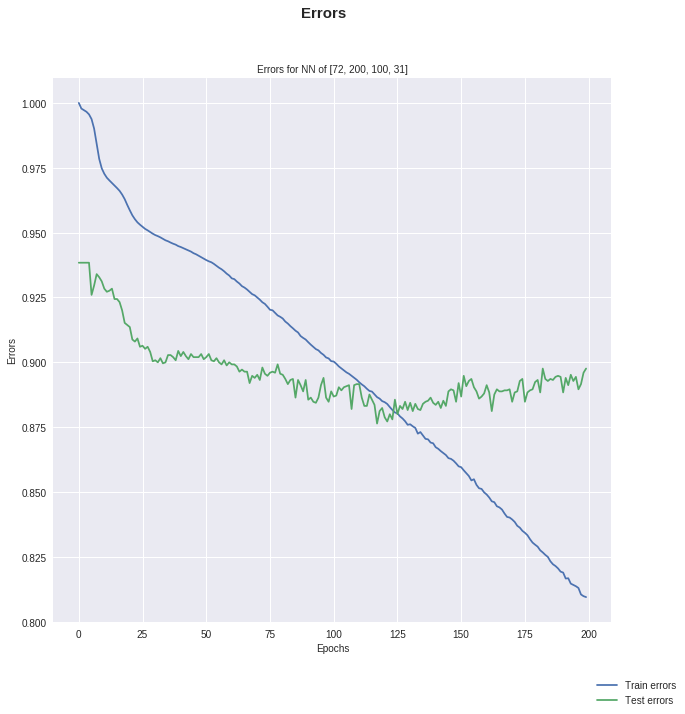

AttributeError: ignored

In [14]:
plot([model])